In [1]:
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt 
import scanpy as sc
import scipy as sp

from numpy.random import default_rng
rng = default_rng(seed=1234)

In [39]:
acinar_sce = sc.read_h5ad("/home/ubuntu/data/acinar_sce.h5ad")
acinar_sce.obs.donor_age.unique()

['1', '21', '22', '38', '44', '54', '5', '6']
Categories (8, object): ['1', '5', '6', '21', '22', '38', '44', '54']

In [58]:
# Revant's highly variable genes
import pandas as pd

hvg = pd.read_csv("/home/ubuntu/data/Revant_Data/acinar_hvg_genes.txt", sep="\t")
hvg = hvg.x.str.replace(".", "-")
hvg = list(hvg)
len(hvg)

827

# Run PyPsupertime

In [59]:
from pypsupertime import Psupertime
from pypsupertime.preprocessing import transform_labels
import scanpy as sc

#anndata = sc.read_h5ad("/home/ubuntu/data/acinar_sce.h5ad")
#ordinal_labels = transform_labels(anndata.obs.donor_age)

psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "list", "gene_list": hvg},
                    n_jobs=5,
                    n_batches=5)

adata = psuper.run("/home/ubuntu/data/acinar_sce.h5ad", "donor_age")

Input Data: n_genes=23368, n_cells=411
Preprocessing: done. mode='list', n_genes=827, n_cells=411
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.583942.02, n_genes=23
Total elapsed time:  0:01:37.792169


Best idx: 18 Best Score: 0.6424331472230386 Best Lambda: 0.014251026703029985 Scores std: 0.1623145605054298
1SE idx: 14 1SE Score: 0.581516309138995 1SE Lambda: 0.03665241237079628


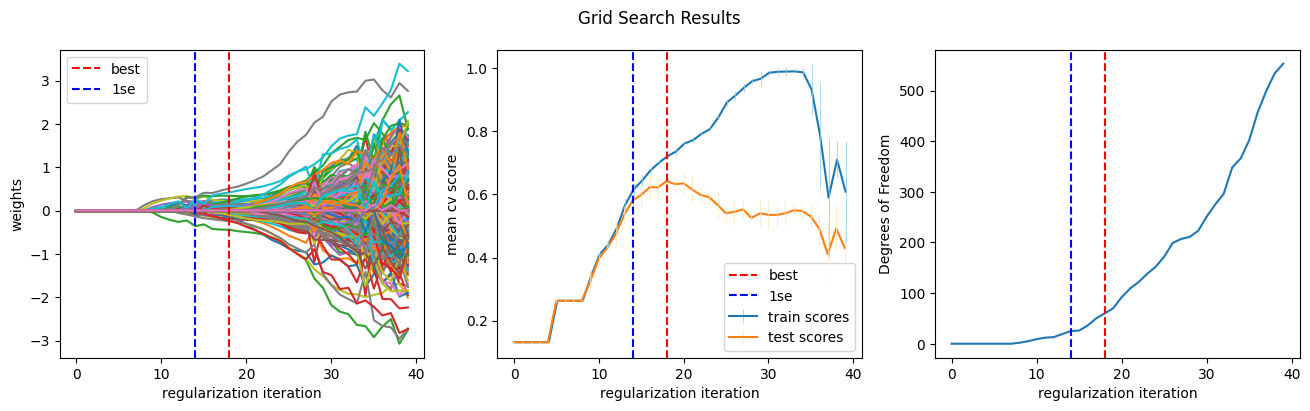

In [60]:
_ = psuper.plot_grid_search()

In [61]:
psuper.refit_and_predict(adata, "best")

Input Data: n_genes=827, n_cells=411
Refit on all data: done. accuracy=0.703163.02, n_genes=64


Model Degrees of freedom 64
Accuracy: 0.7031630170316302
Balanced accuracy: 0.488401230177546
Mean absolute delta: 0.7296790211263895


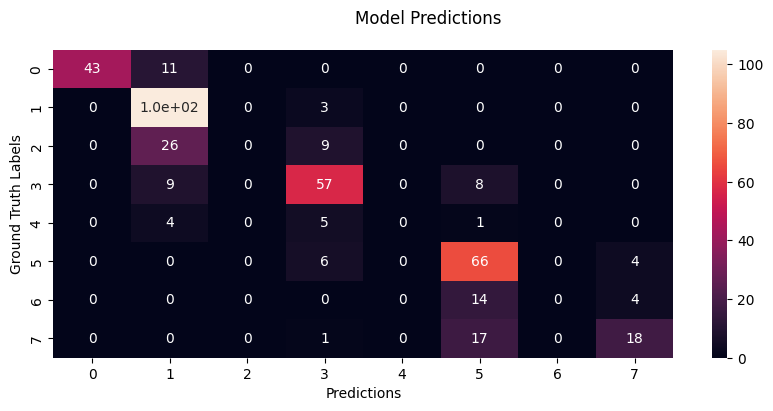

In [62]:
_ = psuper.plot_model_perf(train=(adata.X, adata.obs.ordinal_label))

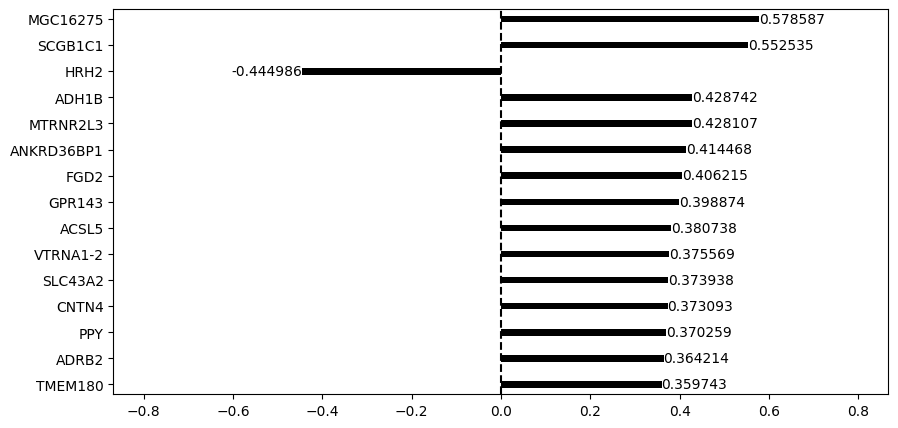

In [26]:
_ = psuper.plot_identified_gene_coefficients(adata, n_top=15, figsize=(10,5))

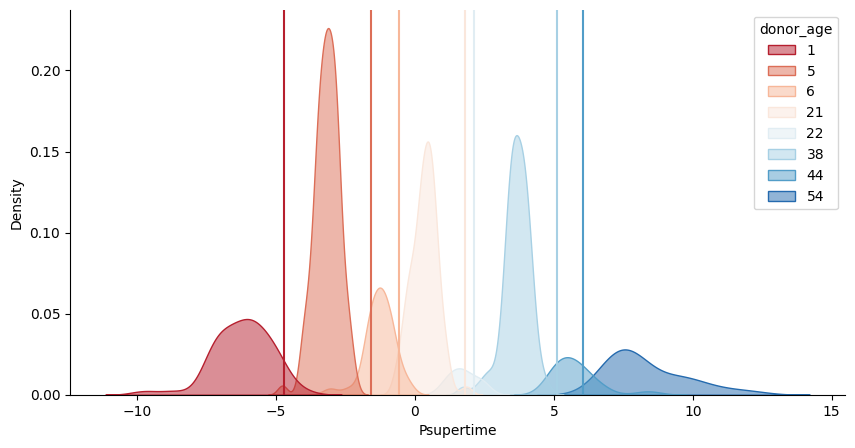

In [27]:
fig = psuper.plot_labels_over_psupertime(adata, "donor_age")
#fig.get_axes()[0].set_xlim((0,50))

In [28]:
import numpy as np
from sklearn import metrics
print("Abs Error:", metrics.mean_absolute_error(adata.obs.ordinal_label, adata.obs.predicted_label))
print("Accuracy:", metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
print("Balanced Acc:", metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))

n_genes_start = 26178
dof =  np.count_nonzero(psuper.model.coef_)
print("DoF (sparsity): %s (%s)" % (dof, 1 - (dof / n_genes_start) ))

Abs Error: 0.1630170316301703
Accuracy: 0.8394160583941606
Balanced Acc: 0.6198830409356726
DoF (sparsity): 442 (0.9831155932462373)


## Highly Variable genes Revant vs Python

In [54]:
import pandas as pd

hvg = pd.read_csv("/home/ubuntu/data/Revant_Data/acinar_hvg_genes.txt", sep="\t")
hvg = hvg.x.str.replace(".", "-")
hvg = list(hvg)

py_hvg = list(adata.var_names)
# NOT ONE GENE IN COMMON!!!
set(py_hvg).intersection(set(hvg))

827

## Repeat on Different Seeds

In [29]:
seeds = [25, 341, 654, 2452, 89]
acc_best = []
acc_1se = []
bacc_best = []
bacc_1se = []
dof_best = []
dof_1se = []

In [34]:
from pypsupertime import Psupertime
from pypsupertime.preprocessing import transform_labels
import scanpy as sc

for i, s in enumerate(seeds):
    print("Iter %i, seed %i" % (i, s))
    
    psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "hvg"},
                    n_jobs=5,
                    n_batches=1,
                    random_state=s)
    adata = psuper.run("/home/ubuntu/data/acinar_sce.h5ad", "donor_age")

    acc_1se.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_1se.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_1se.append(dof)

    # refit and predict best model
    psuper.refit_and_predict(adata, "best")
    acc_best.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_best.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_best.append(dof)

Iter 0, seed 25
Input Data: n_genes=23368, n_cells=411
Preprocessing: done. mode='hvg', n_genes=956, n_cells=411
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.364964.02, n_genes=77
Total elapsed time:  0:01:19.974433
Input Data: n_genes=956, n_cells=411
Refit on all data: done. accuracy=0.474453.02, n_genes=120
Iter 1, seed 341
Input Data: n_genes=23368, n_cells=411
Preprocessing: done. mode='hvg', n_genes=956, n_cells=411
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.374696.02, n_genes=75
Total elapsed time:  0:01:33.710140
Input Data: n_genes=956, n_cells=411
Refit on all data: done. accuracy=0.846715.02, n_genes=502
Iter 2, seed 654
Input Data: n_genes=23368, n_cells=411
Preprocessing: done. mode='hvg', n_genes=956, n_cells=411
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.384428.02, n_genes=74
Total elapsed time:  0:01:46.566950
Input Data:

In [43]:
import numpy as np

num_input_genes = 23368
hvg = 956

print("1se model")
print("accuracy: %s (%s)" % (np.mean(acc_1se), np.std(acc_1se)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_1se), np.std(bacc_1se)))
print("dof: %s (%s)" % (np.mean(dof_1se) , np.std(dof_1se)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_1se) / num_input_genes), np.std(dof_1se) / num_input_genes))
print("Sparsity (hvg): %s (%s)" % (1 - (np.mean(dof_1se) / hvg), np.std(dof_1se) / hvg))
print()

print("best model")
print("accuracy: %s (%s)" % (np.mean(acc_best), np.std(acc_best)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_best), np.std(bacc_best)))
print("dof: %s (%s)" % (np.mean(dof_best) , np.std(dof_best)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_best) / num_input_genes), np.std(dof_best) / num_input_genes))
print("Sparsity (hvg): %s (%s)" % (1 - (np.mean(dof_best) / hvg), np.std(dof_best) / hvg))



1se model
accuracy: 0.4807785888077859 (0.1882794591374225)
balanced accuracy: 0.34655840050576897 (0.14289153717129172)
dof: 160.93333333333334 (161.38627230619363)
Sparsity (all genes): 0.993113089124729 (0.00690629374812537)
Sparsity (hvg): 0.8316596931659693 (0.16881409237049544)

best model
accuracy: 0.7094890510948905 (0.16554026455187393)
balanced accuracy: 0.5193048311469364 (0.12738062659180274)
dof: 341.2 (170.9203323188906)
Sparsity (all genes): 0.9853988360150633 (0.007314290154009354)
Sparsity (hvg): 0.6430962343096234 (0.17878695849256337)


In [64]:
# save results
hvg_acc_best = acc_best
hvg_acc_1se = acc_1se
hvg_bacc_best = bacc_best
hvg_bacc_1se = bacc_1se
hvg_dof_best = dof_best
hvg_dof_1se = dof_1se

## Repeat on Different Seeds (use ALL genes)

In [65]:
seeds = [25, 341, 654, 2452, 89]
acc_best = []
acc_1se = []
bacc_best = []
bacc_1se = []
dof_best = []
dof_1se = []

In [66]:
from pypsupertime import Psupertime
from pypsupertime.preprocessing import transform_labels
import scanpy as sc

for i, s in enumerate(seeds):
    print("Iter %i, seed %i" % (i, s))
    
    psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "all"},
                    n_jobs=5,
                    n_batches=1,
                    random_state=s)
    adata = psuper.run("/home/ubuntu/data/acinar_sce.h5ad", "donor_age")

    acc_1se.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_1se.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_1se.append(dof)

    # refit and predict best model
    psuper.refit_and_predict(adata, "best")
    acc_best.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_best.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_best.append(dof)

Iter 0, seed 25
Input Data: n_genes=23368, n_cells=411
Preprocessing: done. mode='all', n_genes=13564, n_cells=411
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.532847.02, n_genes=77
Total elapsed time:  0:34:41.160527
Input Data: n_genes=13564, n_cells=411
Refit on all data: done. accuracy=0.846715.02, n_genes=282
Iter 1, seed 341
Input Data: n_genes=23368, n_cells=411
Preprocessing: done. mode='all', n_genes=13564, n_cells=411
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.537713.02, n_genes=70
Total elapsed time:  0:38:58.142888
Input Data: n_genes=13564, n_cells=411
Refit on all data: done. accuracy=0.844282.02, n_genes=238
Iter 2, seed 654
Input Data: n_genes=23368, n_cells=411
Preprocessing: done. mode='all', n_genes=13564, n_cells=411
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.452555.02, n_genes=51
Total elapsed time:  0:38:23.959589
I

In [70]:
import numpy as np

def latex_tabular_fmt(acc, dof, n):
    acc_mean = np.round(np.mean(acc) * 100, 2)
    sparsity_mean = np.round((1 - (np.mean(dof) / n)) * 100, 2)
    acc_std = np.round(np.std(acc) * 100, 1)
    sparsity_std = np.round((np.std(dof) / n) * 100, 1)

    latex_template = "$%s \\pm %s$  &  $%s \\pm %s$"
    return latex_template % (acc_mean, acc_std, sparsity_mean, sparsity_std)

num_input_genes = 13564

print("1se model")
print("accuracy: %s (%s)" % (np.mean(acc_1se), np.std(acc_1se)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_1se), np.std(bacc_1se)))
print("dof: %s (%s)" % (np.mean(dof_1se) , np.std(dof_1se)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_1se) / num_input_genes), np.std(dof_1se) / num_input_genes))
print("LATEX: accuracy & sparsity \\\\")
print(latex_tabular_fmt(acc_1se, dof_1se, num_input_genes))
print()

print("best model")
print("accuracy: %s (%s)" % (np.mean(acc_best), np.std(acc_best)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_best), np.std(bacc_best)))
print("dof: %s (%s)" % (np.mean(dof_best) , np.std(dof_best)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_best) / num_input_genes), np.std(dof_best) / num_input_genes))
print("LATEX: accuracy & sparsity \\\\")
print(latex_tabular_fmt(acc_best, dof_best, num_input_genes))


1se model
accuracy: 0.5148418491484186 (0.03163391331025792)
balanced accuracy: 0.41823896264685745 (0.01889616612763934)
dof: 69.2 (9.453041838477178)
Sparsity (all genes): 0.9948982601002654 (0.0006969213977054835)
LATEX: accuracy & sparsity \\
$51.48 \pm 3.2$  &  $99.49 \pm 0.1$

best model
accuracy: 0.8457420924574208 (0.001191965811573321)
balanced accuracy: 0.6244395711500974 (0.0007034697871955391)
dof: 275.6 (20.362711017936686)
Sparsity (all genes): 0.9796815098790917 (0.0015012320125285083)
LATEX: accuracy & sparsity \\
$84.57 \pm 0.1$  &  $97.97 \pm 0.2$


# Significant Genes

In [11]:
PY_GENES = anndata.var[anndata.var["psupertime_weights"] != 0].index

In [12]:
# > dput(as.character(pobj_all$beta_dt[pobj_all$beta_dt$beta != 0]$symbol))
R_GENES = ["INS", "ELF3", "RAP2A", "MLLT6", "HSP90AA1", "RXRB", "EFEMP2", 
"PTP4A3", "ZNF862", "NFKB1", "C18orf1", "TMEM234", "LOC285441", 
"ERCC2", "ITM2A", "MTA3", "SCGB1C1", "STAB2", "IREB2", "NOTCH4", 
"CYB5D2", "SS18", "ASB3", "PODXL", "FAM135A", "SNORA76", "JMJD5", 
"AS3MT", "AKIRIN2", "MFN2", "SMURF2", "GATAD1", "AHSA2", "C4orf47", 
"GATSL3", "SLC2A10", "RNU12", "LOC389247", "SNORD54", "PPY", 
"SERPINA3", "CFLAR.AS1", "FAM20C", "ELP4", "VTRNA1.3", "SLCO2B1", 
"SGCE", "SGK1", "LOC399715", "SNORA80B", "RNF186", "DHX8", "TTC28", 
"ZBTB17", "C10orf54", "C14orf21", "C21orf119", "CELF5", "TMEM194A", 
"EPN2", "LOC100306975", "SNORA9", "MADD", "LOC285758", "ARVCF", 
"KIAA1383", "NECAB1", "SPEF2", "SNORD63", "WDR20", "TMEM229B", 
"CYS1", "C16orf89", "GAD1", "SYT15", "OXCT1", "ONECUT1", "PEX5L", 
"ATE1", "ULK3", "PEG3", "SNORA80", "CDC14B", "TDH", "C4orf32", 
"MMP24", "AACS", "GALNT1", "STS", "AHDC1", "ETNK2", "FUZ", "ZNF317", 
"AZGP1", "ABCF1", "DLL1", "PANK1", "DUSP4", "UBAP2", "MIR4712"]

In [13]:
sum([g in PY_GENES for g in R_GENES]) / len(R_GENES)

0.12

# Plot labels over psupertime